https://www.kaggle.com/code/ludovicocuoghi/twitter-sentiment-analysis-with-bert-roberta#BERT-Sentiment-Analysis


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install demoji
! pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 4.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.2 MB/s eta 0:00:0

In [3]:
#Load the libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import demoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

In [4]:
import os
os.getcwd()
os.chdir('/content/drive/MyDrive/MBD/analisis_de_datos_no_estructurados/practica_texto')
print(os.listdir("data/"))

['Corona_NLP_test.csv', 'Corona_NLP_train.csv']


In [5]:
import warnings
warnings.filterwarnings('ignore')

corona_data_train = pd.read_csv('data/Corona_NLP_train.csv', encoding='cp437', on_bad_lines = 'skip')
# corona_data_train = corona_data_train.loc[(corona_data_train['Sentiment'] == "Positive") | (corona_data_train['Sentiment'] == "Negative")]

corona_data_test = pd.read_csv('data/Corona_NLP_test.csv', encoding='cp437', on_bad_lines = 'skip')
# corona_data_test = corona_data_test.loc[(corona_data_test['Sentiment'] == "Positive") | (corona_data_test['Sentiment'] == "Negative")]

print("TRAIN", corona_data_train.shape)
print("TEST", corona_data_test.shape)

TRAIN (41157, 6)
TEST (3798, 6)


In [6]:
corona_data_train.head()

UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

In [7]:
# Eliminamos duplicados en caso de que haya alguno
corona_data_train.drop_duplicates(subset='OriginalTweet',inplace=True)

## Limpieza del dataset

In [8]:
corona_data_train = corona_data_train[['OriginalTweet','Sentiment']]
corona_data_test = corona_data_test[['OriginalTweet','Sentiment']]

Definimos algunas funciones para limpiar el dataset

In [9]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return demoji.replace(text, '')#re.sub(emoji.emoji_list(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

Ejecutamos todas las funciones definidas para los datasets de train y test

In [10]:
texts_new = []
for t in corona_data_train.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [11]:
texts_new_test = []
for t in corona_data_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

Creamos una nueva columna en cada dataframe con el texto que acabamos de limpiar

In [12]:
corona_data_train['text_clean'] = texts_new
corona_data_test['text_clean'] = texts_new_test

In [13]:
corona_data_train['text_clean'].head()

0                                              and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: text_clean, dtype: object

In [14]:
corona_data_test['text_clean'].head()

0    trending new yorkers encounter empty supermark...
1    when i couldnt find hand sanitizer at fred mey...
2    find out how you can protect yourself and love...
3    panic buying hits newyork city as anxious shop...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: text_clean, dtype: object

Vamos a comprobar si, al hacer la limpieza del texto de los tweets, hemos borrado demasiado contenido, o si tenemos texto suficiente con el que entrenar el modelo

In [15]:
text_len = []
for text in corona_data_train.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

text_len_test = []
for text in corona_data_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

corona_data_train['text_len'] = text_len
corona_data_test['text_len'] = text_len_test


In [16]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=corona_data_train[corona_data_train['text_len']<10], palette='mako')
plt.title('Tweets del df de entrenamiento con menos de 10 palabras')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

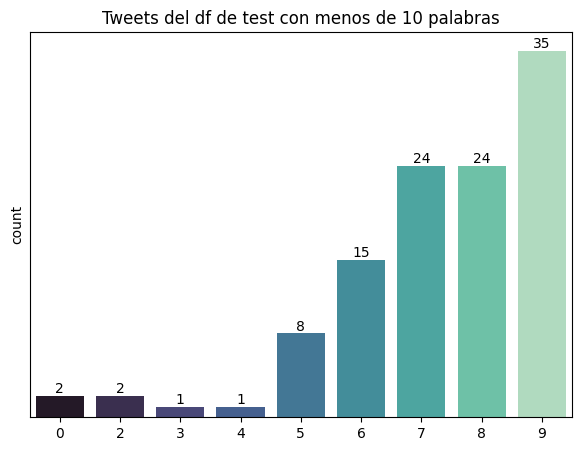

In [17]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=corona_data_test[corona_data_test['text_len']<10], palette='mako')
plt.title('Tweets del df de test con menos de 10 palabras')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [18]:
print(f" DF SHAPE: {corona_data_train.shape}")
print(f" DF TEST SHAPE: {corona_data_test.shape}")

 DF SHAPE: (41157, 4)
 DF TEST SHAPE: (3798, 4)


Vamos a quedarnos solamente con los tweets que tengan más de 5 palabras, para poder analizar oraciones lo suficientemente largas para sacar conclusiones de ellas.

In [19]:
corona_data_train = corona_data_train[corona_data_train['text_len'] > 5]
corona_data_test = corona_data_test[corona_data_test['text_len'] > 5]

In [20]:
print(f" DF SHAPE: {corona_data_train.shape}")
print(f" DF TEST SHAPE: {corona_data_test.shape}")

 DF SHAPE: (40798, 4)
 DF TEST SHAPE: (3784, 4)


Ahora, vamos a usar el tokenizador de bert para realizar una mayor limpieza del código, y poder pasarle al modelo datos con la estructura que desea, de forma que pueda extraer la maxima informacion posible

In [21]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [22]:
token_lens_train = []
token_lens_test = []

for txt in corona_data_train['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_train.append(len(tokens))

for txt in corona_data_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len_train=np.max(token_lens_train)
max_len_test=np.max(token_lens_test)

print(f"Oracion más larga tras tokenizacion en train: {max_len_train}")
print(f"Oracion más larga tras tokenizacion en train: {max_len_test}")

Oracion más larga tras tokenizacion en train: 100
Oracion más larga tras tokenizacion en train: 96


Al analizar los dataframes resultantes, vemos que hay oraciones que no están en inglés. Estas deberemos eliminarlas para que no interfieran en el reentrenamiento del modelo

In [23]:
corona_data_train['token_lens'] = token_lens_train
corona_data_train = corona_data_train.sort_values(by='token_lens', ascending=False)
corona_data_train.head(20)

OriginalTweet           Sentiment  \
1638   Z├ísah policie proti spekulant?m s rou┬Ükami. ...             Neutral   
37156  11 Nisan Cumartesi itibariyle ?BB┬Ænin t├╝m hi...             Neutral   
16632  Bir m├╝ddettir s├╝permarketlerin lojistik hizm...             Neutral   
13691  Hoy aplaudo a mi segunda familia #AplaudoANues...             Neutral   
27005  Supermercados Econo confirman que un empleado ...             Neutral   
28899  Kindly contact Us bamy global merchandise for ...            Positive   
14593  Na, wer war denn da am Werk? Gestern Nachmitta...  Extremely Negative   
18913  #CroozefmNews \r\r\nPresident Museveni has ord...  Extremely Negative   
11213  Keine Wertgegenst├ñnde im Fahrzeug lassen! - D...            Negative   
4844   Impct of #coronavirus i hve sen hw civilizd pp...  Extremely Negative   
26678  Eine wahre #CoronaGeschichte:\r\r\n\r\r\nWenn ...             Neutral   
30206  #LDA City Lahore Residential Files Prices Upda...             Neutral   
14582  hiked prices in the face of the Covid-19 crise...            Negative   
8730   ?Bitte anschauen! (1/2)\r\r\n\r\r\nEmotionaler...            Negative   
1697   I work at a grocery store.\r\r\nWe wont get an...            Positive   
12389  Okay, so I just checked the drug prices for #P...            Positive   
36305  Sterile disposable anti bacterial wet wipes an...            Negative   
40330  Grap some for your family and keep in safe, #h...            Positive   
9238   Hi @Zomato I felt hungry loggd in ur app tryd ...  Extremely Positive   
36306  For sell Sterile disposable anti bacterial wet...            Negative   

                                              text_clean  text_len  token_lens  
1638   zsah policie proti spekulantm s roukami na mj ...        39         100  
37156  11 nisan cumartesi itibariyle bbnin tm hizmetl...        39          98  
16632  bir mddettir spermarketlerin lojistik hizmeti ...        36          92  
13691  hoy aplaudo a mi segunda familia aplaudoanuest...        38          84  
27005  supermercados econo confirman que un empleado ...        39          80  
28899  kindly contact us bamy global merchandise for ...        37          80  
14593  na wer war denn da am werk gestern nachmittag ...        37          80  
18913  croozefmnews president museveni has ordered th...        35          79  
11213  keine wertgegenstnde im fahrzeug lassen diesen...        33          79  
4844   impct of coronavirus i hve sen hw civilizd ppl...        48          79  
26678  eine wahre coronageschichte wenn dir an der su...        29          78  
30206  lda city lahore residential files prices updat...        43          78  
14582  hiked prices in the face of the covid19 crises...        47          77  
8730   bitte anschauen 12 emotionaler aufruf von geha...        36          77  
1697   i work at a grocery store we wont get any toil...        37          77  
12389  okay so i just checked the drug prices for pla...        35          77  
36305  sterile disposable anti bacterial wet wipes an...        31          76  
40330  grap some for your family and keep in safe han...        30          75  
9238   hi i felt hungry loggd in ur app tryd to add 4...        55          75  
36306  for sell sterile disposable anti bacterial wet...        32          75

In [24]:
corona_data_train = corona_data_train.iloc[14:]
corona_data_train.head()

OriginalTweet           Sentiment  \
1697   I work at a grocery store.\r\r\nWe wont get an...            Positive   
12389  Okay, so I just checked the drug prices for #P...            Positive   
36305  Sterile disposable anti bacterial wet wipes an...            Negative   
40330  Grap some for your family and keep in safe, #h...            Positive   
9238   Hi @Zomato I felt hungry loggd in ur app tryd ...  Extremely Positive   

                                              text_clean  text_len  token_lens  
1697   i work at a grocery store we wont get any toil...        37          77  
12389  okay so i just checked the drug prices for pla...        35          77  
36305  sterile disposable anti bacterial wet wipes an...        31          76  
40330  grap some for your family and keep in safe han...        30          75  
9238   hi i felt hungry loggd in ur app tryd to add 4...        55          75

In [25]:
corona_data_test['token_lens'] = token_lens_test
corona_data_test = corona_data_test.sort_values(by='token_lens', ascending=False)
corona_data_test.head(20)

OriginalTweet           Sentiment  \
286   @Rhett800cc So hard to decide??. As much as I ...            Negative   
2383  Ahora seguid llorando por el papel higi├⌐nico ...            Negative   
345   Informoval jsem z├ístupce v┬Üech obchodn├¡ch ?...             Neutral   
1485  DTF-Don┬Æt Touch Face\r\r\nDWBH-Do Wash Both H...  Extremely Negative   
1209  I┬æm in the DC/Maryland/Virginia (DMV) area &a...            Positive   
3505  Stop misusing ur privilege amp grow up Some1 c...            Positive   
1789  For those that are cashlong, patient,calm&amp;...  Extremely Positive   
2740  COVID-19: Your government will save ITSELF not...            Positive   
2997  Stop #frenzybuying. You don't need most of wha...  Extremely Negative   
855   Lidl is total chaos, queues as long as the ais...  Extremely Negative   
2177  Yo mama so nasty COVID won't take her\r\r\nYo ...  Extremely Negative   
1895  Today I went to the supermarket for the first ...            Negative   
3735  When there's much need of hamd sanitizers comp...            Negative   
2420  Covid-19 is causing an extreme amount of panic...  Extremely Negative   
1981  As a joke, I was going to post a pic of a roll...  Extremely Negative   
671   Please ppl, I just want to do my normal evenin...            Positive   
1343  I usually stock up on sanitizer like it's doom...            Negative   
2918  obyrne EVAUK actionhunger may food union spark...  Extremely Negative   
3560  What's the craziest thing you've done in the l...            Negative   
300   Don┬Æt let be lumped in with Toliet paper user...             Neutral   

                                             text_clean  text_len  token_lens  
286   so hard to decide as much as i want to hodl my...        38          96  
2383  ahora seguid llorando por el papel higinico qu...        44          94  
345   informoval jsem zstupce vech obchodnch etzc o ...        31          86  
1485  dtfdont touch face dwbhdo wash both hands gtfo...        42          77  
1209  im in the dcmarylandvirginia dmv area amphave ...        45          74  
3505  stop misusing ur privilege amp grow up some1 c...        57          73  
1789  for those that are cashlong patientcalmamphave...        44          71  
2740  covid19 your government will save itself not y...        43          70  
2997  stop frenzybuying you dont need most of what y...        38          70  
855   lidl is total chaos queues as long as the aisl...        62          70  
2177  yo mama so nasty covid wont take her yo mama s...        53          69  
1895  today i went to the supermarket for the first ...        49          69  
3735  when theres much need of hamd sanitizers compa...        43          69  
2420  covid19 is causing an extreme amount of panic ...        54          69  
1981  as a joke i was going to post a pic of a roll ...        55          69  
671   please ppl i just want to do my normal evening...        51          68  
1343  i usually stock up on sanitizer like its dooms...        50          67  
2918  obyrne evauk actionhunger may food union spark...        56          67  
3560  whats the craziest thing youve done in the las...        44          67  
300   dont let be lumped in with toliet paper users ...        30          67

In [26]:
corona_data_test = corona_data_test.iloc[5:]
corona_data_test.head()

OriginalTweet           Sentiment  \
3505  Stop misusing ur privilege amp grow up Some1 c...            Positive   
1789  For those that are cashlong, patient,calm&amp;...  Extremely Positive   
2740  COVID-19: Your government will save ITSELF not...            Positive   
2997  Stop #frenzybuying. You don't need most of wha...  Extremely Negative   
855   Lidl is total chaos, queues as long as the ais...  Extremely Negative   

                                             text_clean  text_len  token_lens  
3505  stop misusing ur privilege amp grow up some1 c...        57          73  
1789  for those that are cashlong patientcalmamphave...        44          71  
2740  covid19 your government will save itself not y...        43          70  
2997  stop frenzybuying you dont need most of what y...        38          70  
855   lidl is total chaos queues as long as the aisl...        62          70

## Análisis de la columna de sentimientos

In [27]:
corona_data_train['Sentiment'].value_counts()

Positive              11354
Negative               9857
Neutral                7485
Extremely Positive     6616
Extremely Negative     5472
Name: Sentiment, dtype: int64

Vamos a codificarlos numéricamente para el entrenamiento. Además, vamos a unificar las clases "Extremely Negative" y "Negative", así como "Extremely Positive" y "Positive"

In [28]:
corona_data_train['Sentiment'] = corona_data_train['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
corona_data_test['Sentiment'] = corona_data_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [29]:
corona_data_train['Sentiment'].value_counts()

2    17970
0    15329
1     7485
Name: Sentiment, dtype: int64

In [30]:
corona_data_test['Sentiment'].value_counts()

0    1629
2    1541
1     609
Name: Sentiment, dtype: int64

## Train validation test split

En primer lugar balanceamos las clases del conjunto de entrenamiento

In [31]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(corona_data_train['text_clean']).reshape(-1, 1), np.array(corona_data_train['Sentiment']).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment'])

In [32]:
train_os['Sentiment'].value_counts()

2    17970
0    17970
1    17970
Name: Sentiment, dtype: int64

In [33]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

X_test = corona_data_test['text_clean'].values
y_test = corona_data_test['Sentiment'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

Realizamos un OneHotEncoding de las clases, para agilizar el entrenamiento.

In [34]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48519
VALIDATION DATA: 5391
TESTING DATA: 3779


## Entrenamiento del modelo BERT-BASE-UNCASED

In [35]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [36]:
MAX_LEN=128

In [37]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [38]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [39]:
checkpoint_path = "checkpoints/saved-model-{epoch:02d}.hdf5"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    save_freq='epoch'
)

In [40]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32, callbacks=[checkpoint])

Epoch 1/4
1517/1517 [==============================] - 242s 128ms/step - loss: 0.5674 - categorical_accuracy: 0.7728 - val_loss: 0.3434 - val_categorical_accuracy: 0.8798
Epoch 2/4
1517/1517 [==============================] - 157s 103ms/step - loss: 0.2935 - categorical_accuracy: 0.8956 - val_loss: 0.2565 - val_categorical_accuracy: 0.9134
Epoch 3/4
1517/1517 [==============================] - 155s 102ms/step - loss: 0.1977 - categorical_accuracy: 0.9307 - val_loss: 0.2154 - val_categorical_accuracy: 0.9293
Epoch 4/4
1517/1517 [==============================] - 153s 101ms/step - loss: 0.1340 - categorical_accuracy: 0.9546 - val_loss: 0.2159 - val_categorical_accuracy: 0.9390


Vemos los resultados

In [41]:
result_bert = model.predict([test_input_ids,test_attention_masks])

119/119 [==============================] - 8s 39ms/step


In [42]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [46]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [48]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [45]:
print('Classification Report for BERT:\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

Classification Report for BERT:
               precision    recall  f1-score   support

    Negative       0.90      0.91      0.91      1629
     Neutral       0.81      0.83      0.82       609
    Positive       0.92      0.89      0.90      1541

   micro avg       0.89      0.89      0.89      3779
   macro avg       0.87      0.88      0.88      3779
weighted avg       0.89      0.89      0.89      3779
 samples avg       0.89      0.89      0.89      3779

